https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 
x-ray data 폐렴 구분 AI 모델
2.2 : NOMAL, PNEUMONIA 2진분류 => NOMAL, VIRAL PNEUMONIA, VACTERIAL PNEUMONIA

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf  # require tf version > 2.7.0
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9744564457491694609
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4975187744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11747110969506437697
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


'2.4.1'

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, schedules

import pandas as pd
import seaborn as sns
import numpy as np


In [2]:
train_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/train'
validation_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/val'
test_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/test'

nb_train_samples = len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/NORMAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/VIRAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/BACTERIAL/'))
nb_validation_samples = len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/NORMAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/VIRAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/BACTERIAL/'))
print(nb_train_samples)
print(nb_validation_samples)

4762
475


[1201, 1198, 2363]


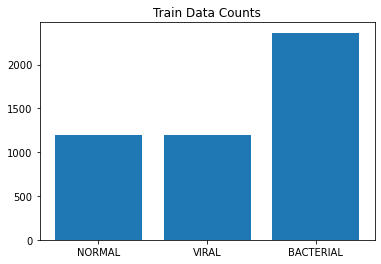

In [3]:
label = ['NORMAL','VIRAL', 'BACTERIAL']

train_counts = [len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/NORMAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/VIRAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/BACTERIAL/'))]
print(train_counts)

plt.bar(label, train_counts)
plt.title('Train Data Counts')
plt.show()

[148, 152, 175]


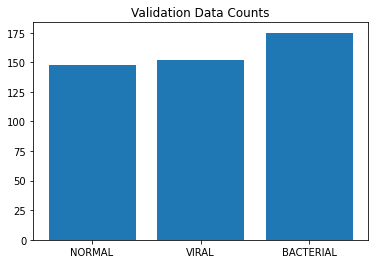

In [4]:
val_counts = [len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/NORMAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/VIRAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/BACTERIAL/'))]
print(val_counts)


plt.bar(label, val_counts)
plt.title('Validation Data Counts')
plt.show()

[234, 145, 242]


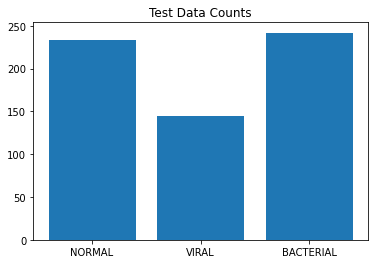

In [5]:
test_counts = [len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/test/NORMAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/test/VIRAL/')), len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/test/BACTERIAL/'))]
print(test_counts)

plt.bar(label, test_counts)
plt.title('Test Data Counts')
plt.show()

In [6]:
img_width = 250
img_height = 300
img_channel = 3

In [7]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_height, img_width, img_channel))

In [8]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 124, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
len(model.layers)
len(base_model.layers)

311

In [11]:
# for i in range(len(model.layers)):
#     if i < len(base_model.layers):
#         model.layers[i].trainable = False

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 124, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

tf 2.7 이상버전에서는 이럴게 설정하고 optimizer 인자에 learning_rate에 바로 줄 수 있음.

In [13]:
# initial_learning_rate = 0.01
# first_decay_steps = 100
# c_learning_rate = schedules.CosineDecayRestarts(
#     initial_learning_rate, 
#     first_decay_steps, 
#     t_mul=1.5, 
#     m_mul=0.9, 
#     alpha=0.01,
#     name=None
# )
# adam = Adam(learning_rate = c_learning_rate)

#tf.keras.optimizers.schedules.CosineDecayRestarts
구현 

In [15]:
import tensorflow as tf
import tensorflow.keras.backend as backend
import math

# CosineAnneling Example.
class CosineAnnealingLearningRateSchedule(tf.keras.callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, min_lr, verbose = 0):
        self.epochs = n_epochs
        self.cycles=  n_cycles
        self.lr_max = lrate_max
        self.min_lr = min_lr
        self.lrates = list()
    
    # caculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        # 전체 epoch / 설정 cycle 수만큼 cycle을 반복합니다.
        epochs_per_cycle = math.floor(n_epochs/n_cycles)
        cos_inner = (math.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        
        return lrate_max/2 * (math.cos(cos_inner) + 1)
  
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs = None):
        if(epoch < 101):
            # calculate learning rate
            lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
            print('\nEpoch %05d: CosineAnnealingScheduler setting learng rate to %s.' % (epoch + 1, lr))
        # 101번째 epoch부터는 해당 설정한 min_lr을 사용
        else:
            lr = self.min_lr
            
        #     elif((epoch >= 65) and (epoch < 75)):
        #       lr = 1e-5
        #       print('\n No CosineAnnealingScheduler set lr 1e-5')
        #     elif((epoch >= 75) and (epoch < 85)):
        #       lr = 1e-6
        #       print('\n No CosineAnnealingScheduler set lr 1e-6')
        #     elif((epoch >= 85)):
        #       lr = 1e-7
        #       print('\n No CosineAnnealingScheduler set lr 1e-7')

        # set learning rate
        # 아래 예제 코드 실행을 위해선 밑 코드를 주석 처리 해주세요.
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

구현한 learning rate 그래프 보기

In [16]:
# cosine_schedule = CosineAnnealingLearningRateSchedule(n_epochs = 100, n_cycles = 5, lrate_max = 1e-3, min_lr = 1e-6)

# for i in range(1, 100 + 1):
#     cosine_schedule.on_epoch_begin(i)
    
# import matplotlib.pyplot as plt

# plt.plot(cosine_schedule.lrates)
# plt.title('Cosine Annealing_Toy')
# plt.xlabel('epochs'); plt.ylabel('learning_rate')
# plt.grid()
# plt.show()

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer= 'adam',
    metrics=['accuracy']
)

In [18]:
epochs = 20
batch_size = 32

In [19]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)

test_datagen = ImageDataGenerator(rescale = 1./255,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4761 images belonging to 3 classes.
Found 474 images belonging to 3 classes.
Found 621 images belonging to 3 classes.


In [25]:
print(len(train_generator.classes[train_generator.classes[:] == 0]))
count_class0 = len(train_generator.classes[train_generator.classes[:] == 0])
print(len(train_generator.classes[train_generator.classes[:] == 1]))
count_class1 = len(train_generator.classes[train_generator.classes[:] == 1])
print(len(train_generator.classes[train_generator.classes[:] == 2]))
count_class2 = len(train_generator.classes[train_generator.classes[:] == 2])
count_total = count_class0 + count_class1 + count_class2
print(count_total)
count_class = 3
print(count_class)

weight_for_0 = (1 / count_class0)*(count_total)/count_class
weight_for_1 = (1 / count_class1)*(count_total)/count_class
weight_for_2 = (1 / count_class2)*(count_total)/count_class

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

2363
1201
1197
4761
3
Weight for class 0: 0.67
Weight for class 1: 1.32
Weight for class 2: 1.33


In [26]:
model_folder = 'C:/Users/s_wnsgk4041/cal/2-2_inceptionV3/'
model_path = model_folder + '{epoch:02d}-{val_loss:.4f}.hdf5'


check_point = ModelCheckpoint(model_path, monitor = 'val_accuracy', save_best_only=False)
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=60, restore_best_weights=True)
cos_learning = CosineAnnealingLearningRateSchedule(n_epochs = 120, n_cycles = 6, lrate_max = 1e-3, min_lr = 1e-6)

In [27]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [check_point,early_stopping, cos_learning],
    class_weight=class_weight)

C:\Users\s_wnsgk4041\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100

Epoch 00001: CosineAnnealingScheduler setting learng rate to 0.001.
148/148 [==============================] - 124s 738ms/step - loss: 1.0710 - accuracy: 0.5806 - val_loss: 0.8491 - val_accuracy: 0.6183
Epoch 2/100

Epoch 00002: CosineAnnealingScheduler setting learng rate to 0.0009938441702975688.
148/148 [==============================] - 105s 706ms/step - loss: 0.6891 - accuracy: 0.7016 - val_loss: 7.9981 - val_accuracy: 0.4933
Epoch 3/100

Epoch 00003: CosineAnnealingScheduler setting learng rate to 0.0009755282581475768.
148/148 [==============================] - 108s 724ms/step - loss: 0.5767 - accuracy: 0.7469 - val_loss: 0.6414 - val_accuracy: 0.6808
Epoch 4/100

Epoch 00004: CosineAnnealingScheduler setting learng rate to 0.0009455032620941839.
148/148 [==============================] - 105s 711ms/step - loss: 0.4963 - accuracy: 0.7791 - val_loss: 4.2748 - val_accuracy: 0.5871
Epoch 5/100

Epoch 00005: CosineAnnealingScheduler setting learng rate to 0.000904508497

148/148 [==============================] - 105s 705ms/step - loss: 0.3739 - accuracy: 0.8113 - val_loss: 0.4730 - val_accuracy: 0.7902
Epoch 37/100

Epoch 00037: CosineAnnealingScheduler setting learng rate to 9.549150281252633e-05.
148/148 [==============================] - 105s 706ms/step - loss: 0.3606 - accuracy: 0.8333 - val_loss: 0.4169 - val_accuracy: 0.7991
Epoch 38/100

Epoch 00038: CosineAnnealingScheduler setting learng rate to 5.449673790581611e-05.
148/148 [==============================] - 105s 707ms/step - loss: 0.3475 - accuracy: 0.8361 - val_loss: 0.5158 - val_accuracy: 0.7812
Epoch 39/100

Epoch 00039: CosineAnnealingScheduler setting learng rate to 2.4471741852423235e-05.
148/148 [==============================] - 105s 705ms/step - loss: 0.3430 - accuracy: 0.8372 - val_loss: 0.4459 - val_accuracy: 0.8147
Epoch 40/100

Epoch 00040: CosineAnnealingScheduler setting learng rate to 6.15582970243117e-06.
148/148 [==============================] - 105s 707ms/step - loss: 0

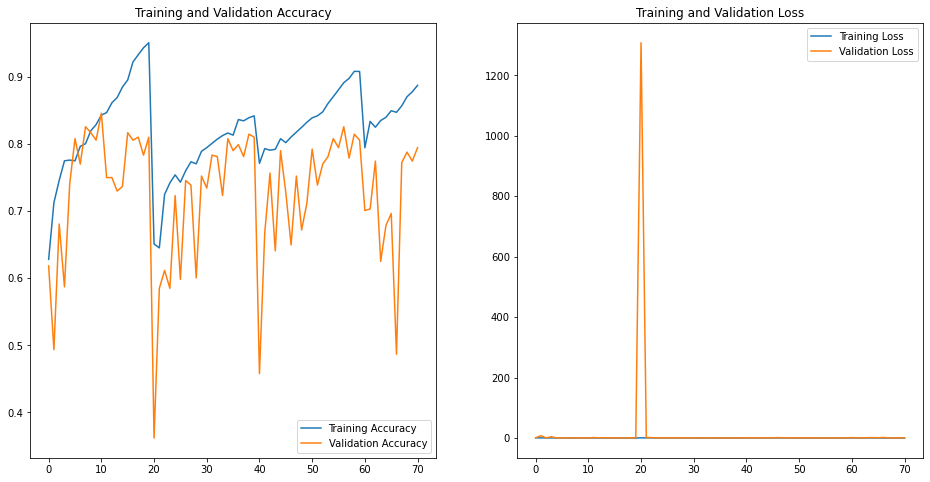

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# from tensorflow.keras.models import load_model
# model = load_model('C:/Users/s_wnsgk4041/cal/2-2_inceptionV3/07-0.4734.hdf5')
# model = load_model('C:/Users/s_wnsgk4041/cal/2-2_inceptionV3/08-0.4464.hdf5')



# model.summary()

In [30]:
scores = model.evaluate_generator(test_generator)

print("\n%s: %.2f" % (model.metrics_names[0], scores[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

C:\Users\s_wnsgk4041\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



loss: 0.63

accuracy: 81.48%
